In [248]:
# all imports I need
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error


#models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

#for pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [77]:
TRAIN_PATH = "train.csv"
TEST_PATH = 'test.csv'
Full_train = pd.read_csv(TRAIN_PATH,index_col='Id')
Full_test = pd.read_csv(TEST_PATH)
Full_train.dropna(axis=0,subset=['SalePrice'], inplace=True)
y_full = Full_train.SalePrice
X_full = Full_train.drop(axis=1, columns=['SalePrice'])

In [78]:
Full_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [79]:
columns_to_drop = ['MoSold','YrSold'] # these columns could be cause of data leakage, it is better to drop them
X_full.drop(columns_to_drop, axis=1, inplace=True)

In [80]:
numeric_col = list((X_full.select_dtypes(exclude='object')).columns)
string_col = list((X_full.select_dtypes(include='object')).columns)
low_categorical_col = [col for col in X_full.columns
                  if X_full[col].dtype == 'object' and X_full[col].nunique() <10]

In [81]:
X_full.shape

(1460, 77)

# Look inside data

## explore data

### numeric data

<ipython-input-7-8928b07a7423>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


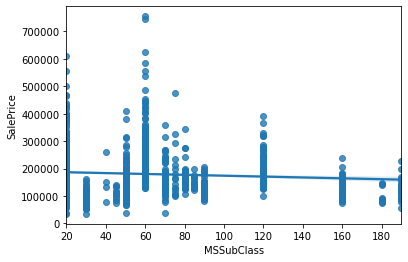

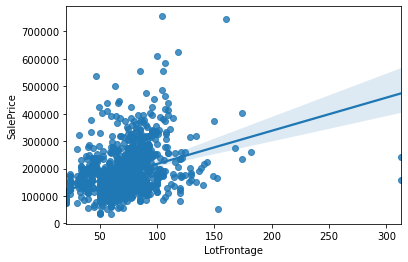

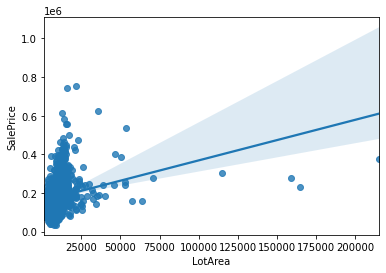

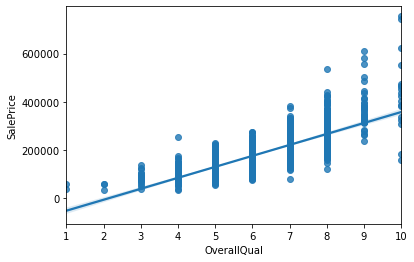

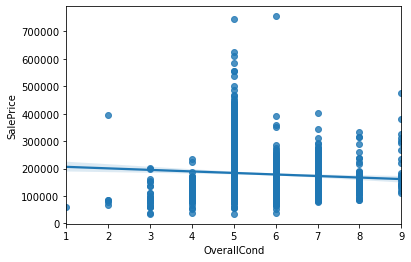

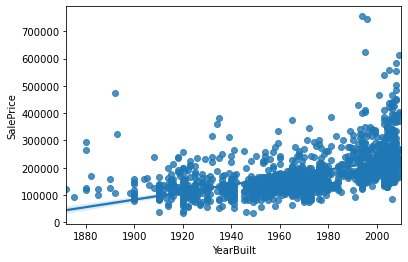

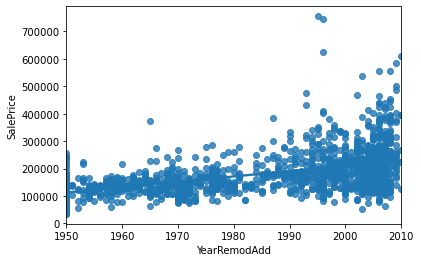

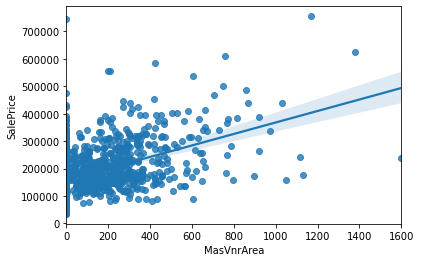

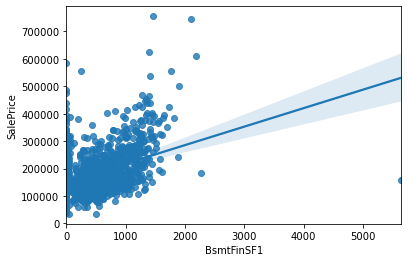

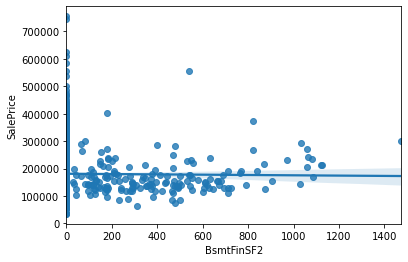

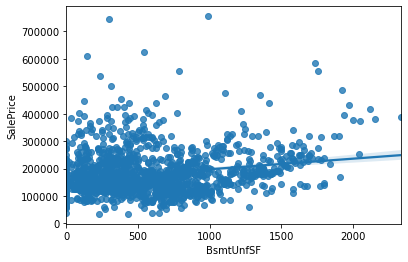

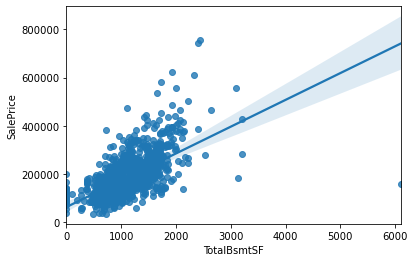

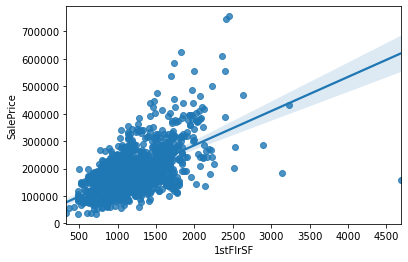

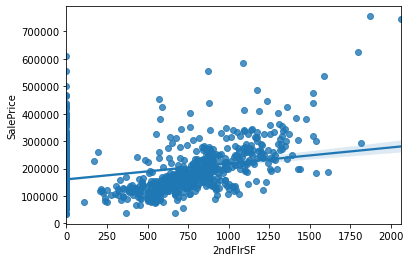

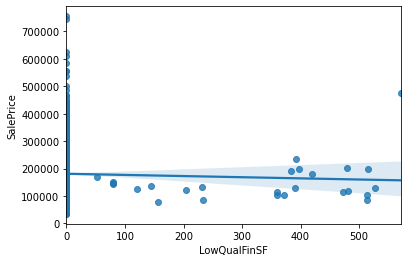

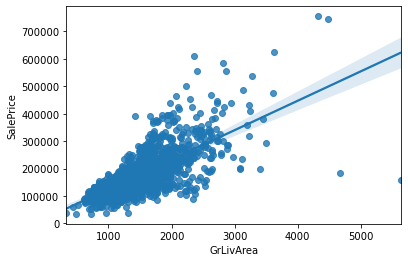

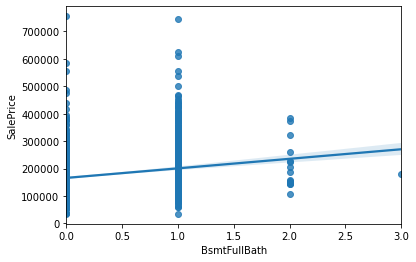

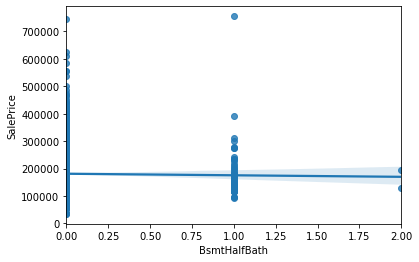

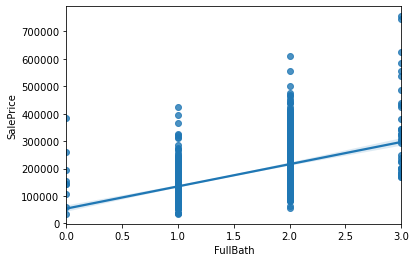

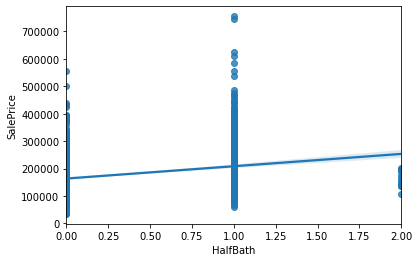

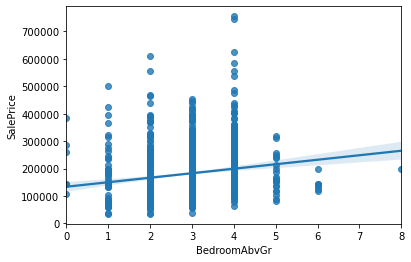

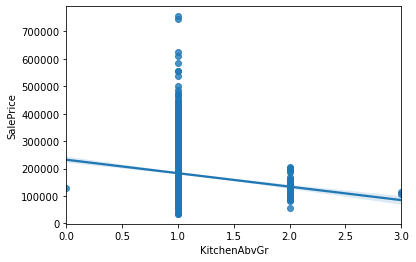

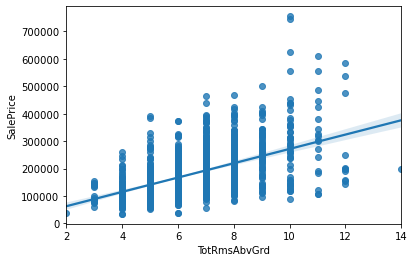

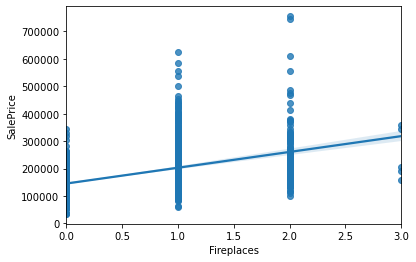

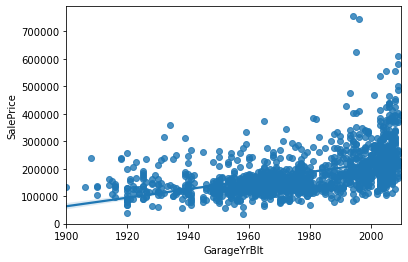

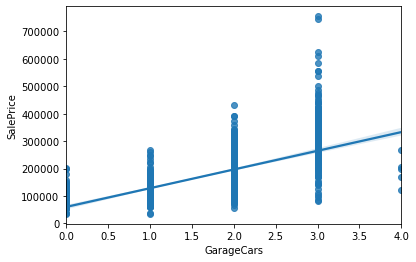

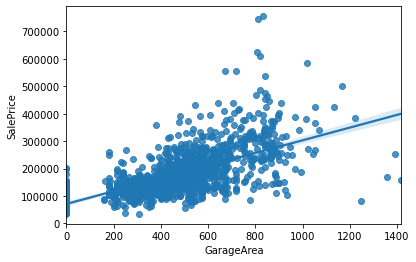

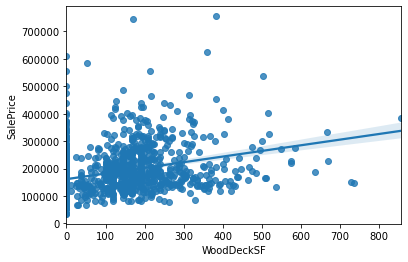

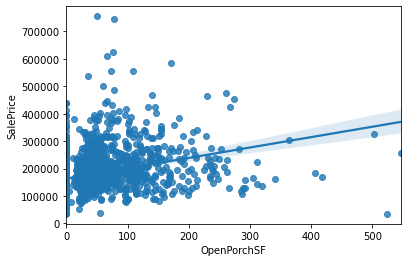

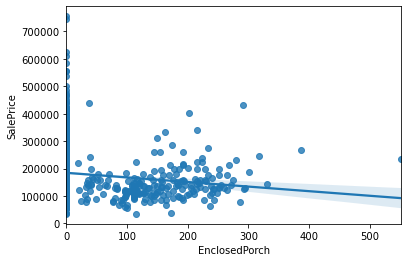

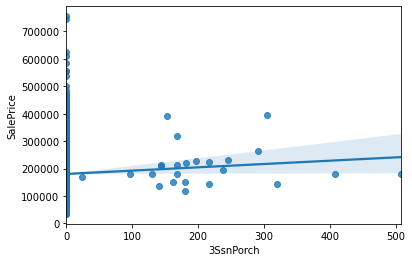

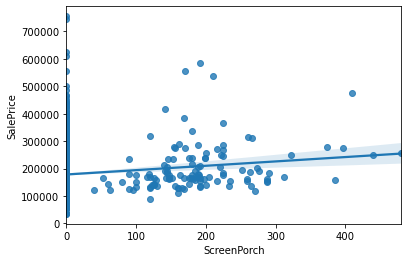

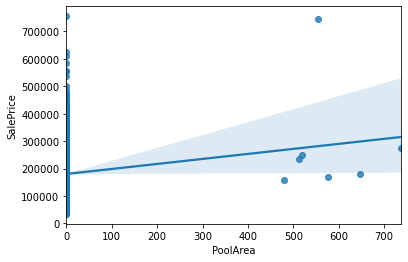

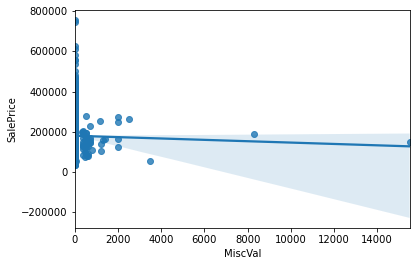

In [7]:
for col in numeric_col:
    plt.figure()
    sns.regplot(x=X_full[col], y=y_full)

In [8]:
#for col in years_to_bin:
#    plt.figure()
 #   sns.regplot(x=X_full[col], y=y_full, order=2, 
 #               scatter_kws={"color": "black"}, line_kws={"color": "red"})

### numeric cols with feature selection

In [9]:
kbest = SelectKBest(f_regression, k=20).fit_transform(SimpleImputer().fit_transform(X_full[numeric_col]), y_full)

### object (string) data

/home/leo/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


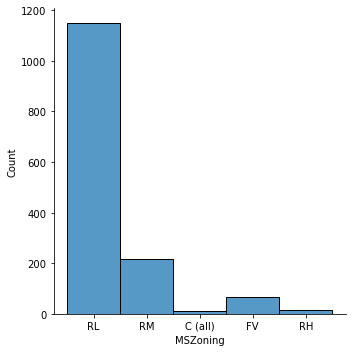

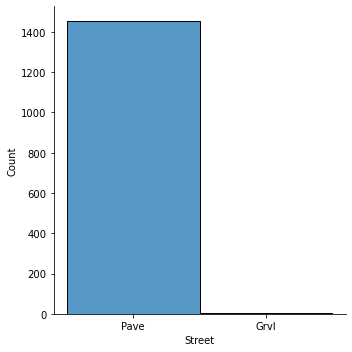

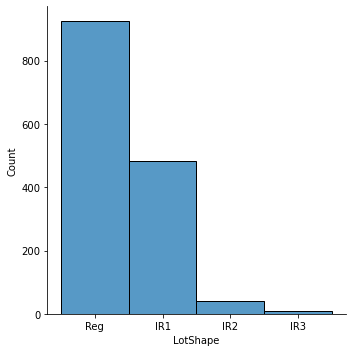

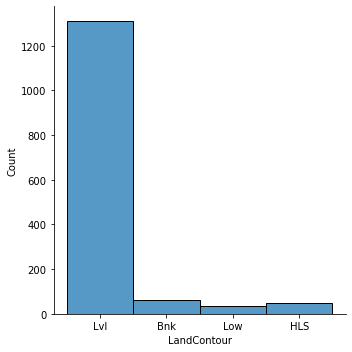

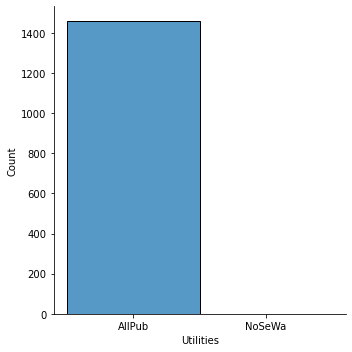

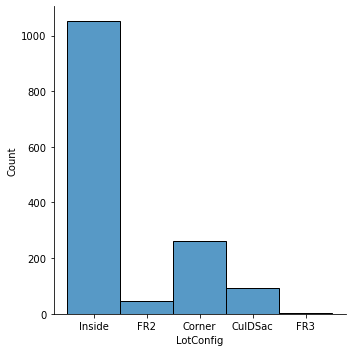

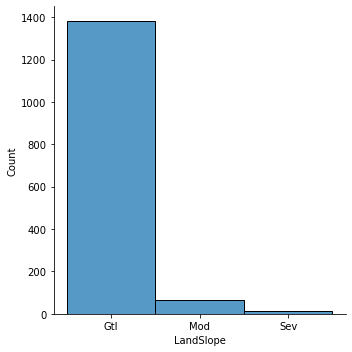

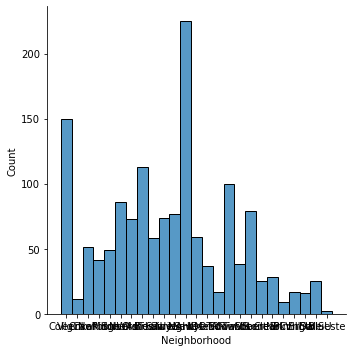

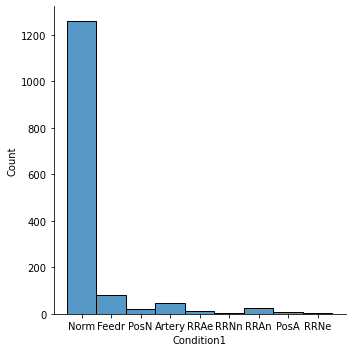

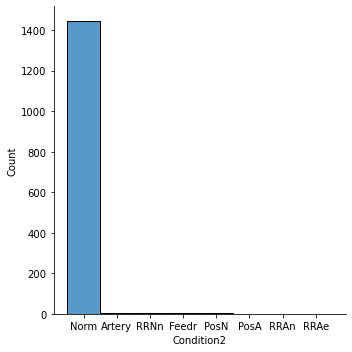

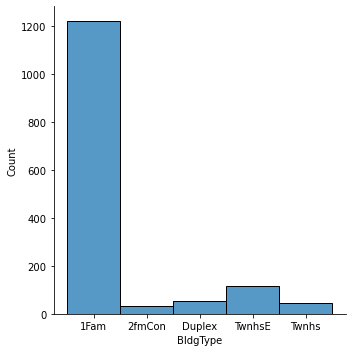

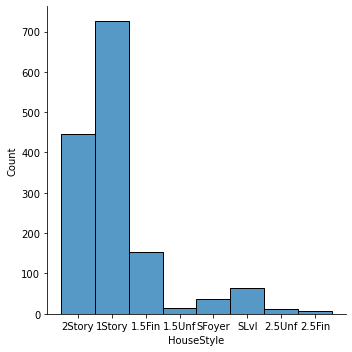

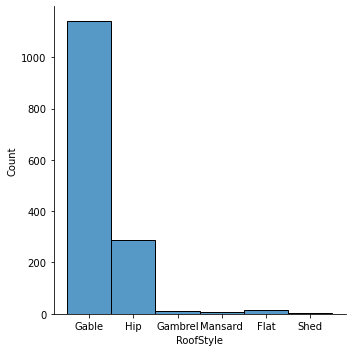

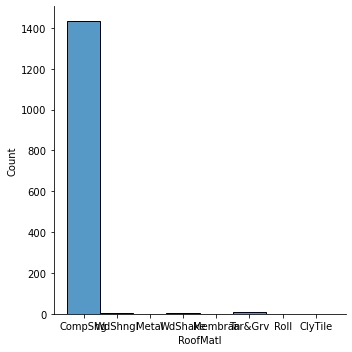

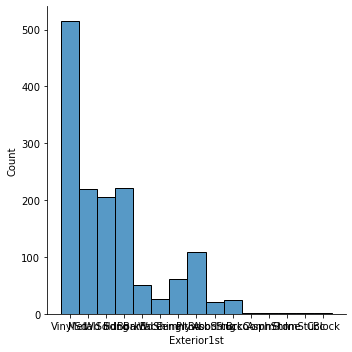

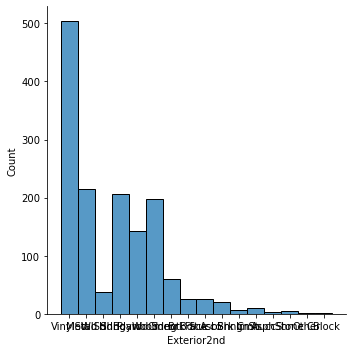

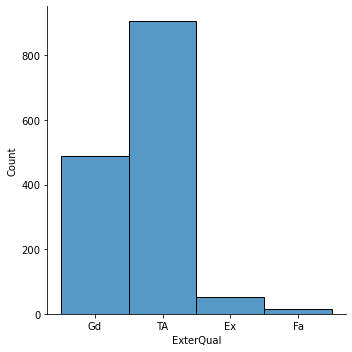

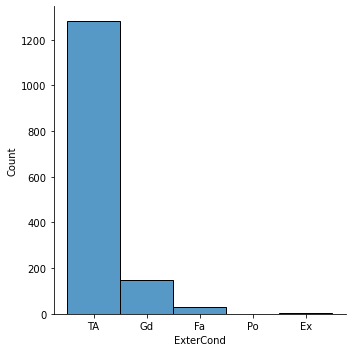

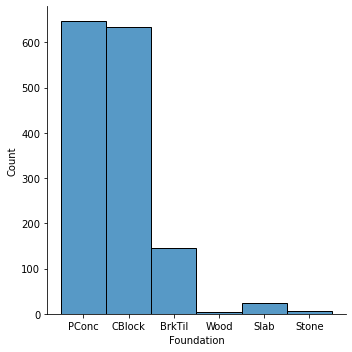

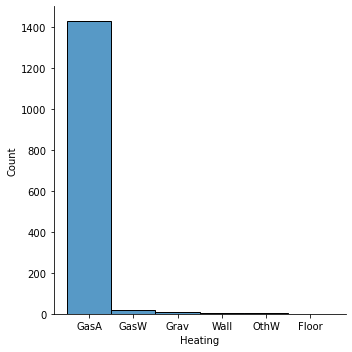

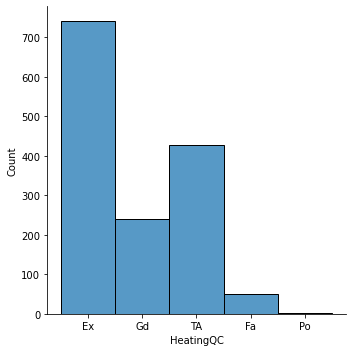

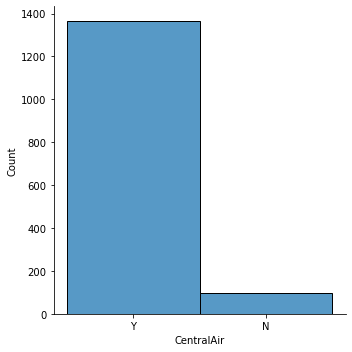

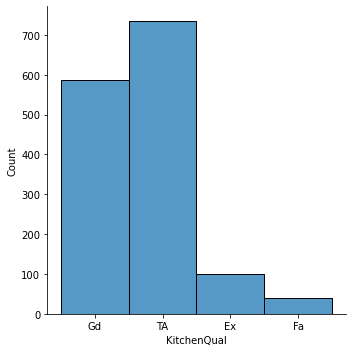

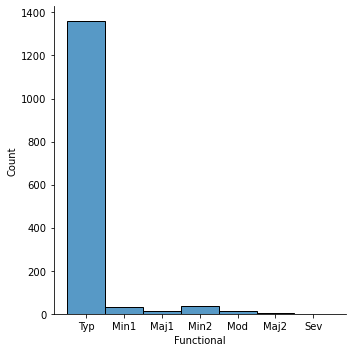

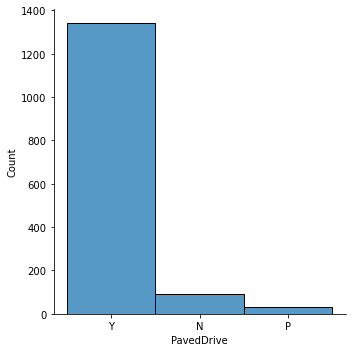

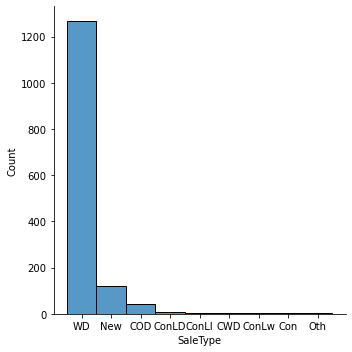

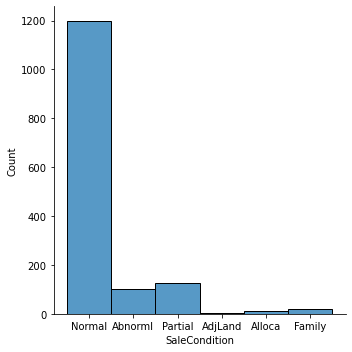

In [10]:
for col in X_full[string_col].dropna(axis=1).columns:
    sns.displot( X_full, x=col)

## Find problems inside data

### find Nan

In [82]:
miss_cols = [col for col in X_full.columns
            if X_full[col].isna().any()]

In [83]:
missing_val_count_by_column = X_full[miss_cols].isna().sum()
print(missing_val_count_by_column)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


# preprocessing

## categorical

In [84]:
X_cat = X_full[low_categorical_col]
X_cat

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In [85]:
cat_nans = X_cat.isna().sum()[X_cat.isna().sum() > 0]
cat_nans

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [86]:
# Not sure why we need BSMtFinType2, it is strange, I will just drop the column
# Need drop\imputation: Electrical
# Should I drop where >1000 missed value?
# in most cases Nan means it is not exist, not missed value, so it is another categorical

### here should be experiments with preprocessing

In [87]:
cols_to_drop = ['BsmtFinType2', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [88]:
X_cat = X_cat.drop(cols_to_drop,axis=1)

In [89]:
cat_features = list(X_cat.columns)

In [90]:
categorical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='None')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [91]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
    ])
model = Pipeline([
    ('prepocess', preprocessor),
    ('model', DecisionTreeRegressor()),
    ])

In [92]:
X_train, X_valid, y_train, y_valid =  train_test_split(X_full[cat_features],
                                                       y_full, random_state=42)

In [95]:
model.fit(X_train, y_train)
prediction = model.predict(X_valid)
mse = mean_squared_error(prediction, y_valid)
mae = mean_absolute_error(prediction, y_valid)
print(mse)
print(mae)

3613461992.358904
37377.01095890411


## numeric

#### dropna
need to drop nan in case to use all numeric cols

In [417]:
print(numeric_col)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [418]:
X_numeric = X_full[numeric_col]
X_numeric

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,2003.0,2,548,0,61,0,0,0,0,0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,1976.0,2,460,298,0,0,0,0,0,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,2001.0,2,608,0,42,0,0,0,0,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,1998.0,3,642,0,35,272,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,2000.0,3,836,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,1999.0,2,460,0,40,0,0,0,0,0
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,1978.0,2,500,349,0,0,0,0,0,0
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,1941.0,1,252,0,60,0,0,0,0,2500


In [419]:
X_numeric.isna().sum()[X_numeric.isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

#### fing numeric columns that needs to bin

In [422]:
numeric_cols_better_to_bin = ['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']
numeric_cols_should_be_categorical = [col for col in X_numeric.columns
                                      if X_numeric[col].nunique() <=20]
cols_to_bin = numeric_cols_better_to_bin + numeric_cols_should_be_categorical
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [421]:
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal']


In [100]:
X_numeric = X_numeric.drop(cols_to_bin, axis=1)
X_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
Id,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,1710,548,0,61,0,0
2,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0
3,68.0,11250,162.0,486,0,434,920,920,866,1786,608,0,42,0,0
4,60.0,9550,0.0,216,0,540,756,961,756,1717,642,0,35,272,0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,836,192,84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,0,0,953,953,953,694,1647,460,0,40,0,0
1457,85.0,13175,119.0,790,163,589,1542,2073,0,2073,500,349,0,0,0
1458,66.0,9042,0.0,275,0,877,1152,1188,1152,2340,252,0,60,0,0


In [101]:
#it is probably best to drop info about pool due to its fewness

# Pipelines

In [280]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid, model=None):
    
    if model is None:
        #model = RandomForestRegressor(random_state=42)
        #model = LinearRegression()
        model = Ridge(normalize=True)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

## only numerical transform

In [232]:
#xxx = X_full[numeric_col]

In [233]:
print(numeric_cols_should_be_categorical)

['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal']


In [234]:
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal']


In [235]:
numeric_cols_better_to_bin

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']

In [236]:
years_to_bin = numeric_cols_better_to_bin[:3]
cols_to_bin_without_years = [col for col in cols_to_bin
                            if col not in years_to_bin]

In [237]:
#features = list(X_numeric.columns) + numeric_cols_should_be_categorical + years_to_bin + string_col

### All numeric data

In [238]:
features = numeric_col

In [239]:
X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features], y_full, random_state=42)

#### at first, let is see how dummy regressor works

In [240]:
dummy_regr = DummyRegressor(strategy='median', constant=0)
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_valid)
print('dummy_regr mae:')
print(mean_absolute_error(pred, y_valid))

dummy_regr mae:
57217.32054794521


Well, we will see, models work much better then dummy regressor

#### Approach 1: 
drop nan columns

In [404]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

print(cols_with_missing)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [405]:
from sklearn.linear_model import Lasso

In [408]:
# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1:")
base_model = Lasso(alpha=1000, max_iter=1000)
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid, base_model)) #22356.59375267366

MAE from Approach 1:
22356.59375267366


#### Approach 2:
Use SimpleImputer to impute missed values

In [411]:
# Imputation
my_imputer = SimpleImputer(strategy='median') # median works quite better
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2:")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid, base_model))

MAE from Approach 2:
22167.217393743205


#### Approach 3:
extention to imputation

In [414]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer(strategy='median') # almost nothing changes, but still quite better
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3:")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid,base_model ))

MAE from Approach 3:
22167.217393743205


### Summary:
It can be seen, that for numerical columns even simple imputation works better then dropping columns(at least for linear regression models), therefore
I will concetrate on checking other techniques, without double-checking how the same techinque will works for dropped columns

#### Approach 4:
Try to use some normalization\scaling techinques

##### Normalization

In [398]:
X_train_norm = X_train.copy()
X_valid_norm= X_valid.copy()

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('normalization', Normalizer()),
    #('model',RandomForestRegressor(random_state=42))
    ('model', Ridge())
    #('model', base_model)
])
print("MAE from Approach 4:")
print(score_dataset(X_train_norm, X_valid_norm, y_train, y_valid, pipe))

MAE from Approach 4:
35376.50886053895


##### scaling

In [399]:
X_train_scale = X_train.copy()
X_valid_scale = X_valid.copy()

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('model', Ridge())
    #('model', base_model)
])
print("MAE from Approach 4:")
print(score_dataset(X_train, X_valid, y_train, y_valid, pipe))
#22433.467501817053

MAE from Approach 4:
22433.467501817053


In [400]:
print(score_dataset(X_train_plus, X_valid_plus, y_train, y_valid, pipe))
#22203.291104332206

22203.291104332206


In [415]:
#cross_validation
cv_scores = cross_val_score(pipe, Full_train[features], y_full, 
                            cv=5,
                            scoring='neg_mean_absolute_error')

print("Cross-validation score: %f" % cv_scores.mean())

Cross-validation score: -21859.744428


## Summary:

## Try some data analysis
Next thing I want to try is creating categories(bins) from numeric data - like ranges from data that contains years, and so on.

In [430]:
numeric_cols_better_to_bin = ['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']
numeric_cols_should_be_categorical = [col for col in X_numeric.columns
                                      if X_numeric[col].nunique() <=20]
cols_to_bin = numeric_cols_better_to_bin + numeric_cols_should_be_categorical
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [432]:
X_numeric['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [401]:
def numeric_transforms_comparation(numerical_transformer, features=numeric_col, n_bins=6):
    # Bundle preprocessing for numerical and categorical data
    cat_from_num_transform = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value=0)),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        #('ord', OrdinalEncoder())
    ])
    cols_to_bin_transform = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('bin', KBinsDiscretizer(n_bins=n_bins, encode='ordinal')),
    ])
    
    categorical_transformer = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, X_numeric.columns), # in this X i dropped columns that I will categorize
            #('num', numerical_transformer, numeric_col),
            ('cat_from_num', cat_from_num_transform, numeric_cols_should_be_categorical),#cols_to_bin
            ('years_to_bin', cols_to_bin_transform, years_to_bin),
            #('cat', categorical_transformer, string_col)
        ], remainder='drop')
    model = Pipeline([
        ('preprocess', preprocessor),
        ('model', LinearRegression()),
    ])
    #dumn = pd.get_dummies(Full_train[low_categorical_col].drop(['Alley'],axis=1))
    #X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features].join(dumn), y_full, random_state=42)
    X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features], y_full, random_state=42)
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    mse = mean_squared_error(prediction, y_valid)
    mae = mean_absolute_error(prediction, y_valid)
    print("mse:", mse)
    print("mae", mae)
    print(n_bins)
    return model

def find_opt_bin(numerical_transformer, max_bin=21):
    for n in range(2,max_bin):
        model=numeric_transforms_comparation(numerical_transformer, n_bins=n)
    return model
#761484416.334323

In [402]:
# numerical transformer - is transformer for columns in X_numeric
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='median') ),
])

In [403]:
model = numeric_transforms_comparation(numerical_transformer,features=features) # n_bins=12 for RandomForestRegressor

mse: 992549087.187378
mae 19333.68974809344
6


In [38]:
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('fe', SelectKBest(f_regression, k=7))
])

In [39]:
model = numeric_transforms_comparation(numerical_transformer,features=features) # n_bins=12 for RandomForestRegressor

mse: 1044706306.6808149
mae 19924.92388969136
6


In [40]:
model = numeric_transforms_comparation(numerical_transformer,features=features,n_bins=12) # n_bins=12 for RandomForestRegressor

mse: 1044974515.9944868
mae 19888.7808300205
12


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [41]:
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('gauss', PowerTransformer()),
   # ('fe', SelectKBest(f_regression, k=7))
])

In [42]:

model = numeric_transforms_comparation(numerical_transformer, features=features)
#model = find_opt_bin(numerical_transformer)

mse: 6.121994416271362e+27
mae 11370989095802.719
6


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [43]:
# scaling
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

In [44]:
model = numeric_transforms_comparation(numerical_transformer, n_bins=10, features=features)

mse: 5.184932599810668e+26
mae 3044580875405.4478
10


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [45]:
# scaling min-max
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

In [46]:
model = numeric_transforms_comparation(numerical_transformer, n_bins=12, features=features)

mse: 2.0377644366328985e+26
mae 1836036708901.8157
12


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [47]:
# best result
#mse: 761484416.334323
#mae 17537.177296803653

## only categorical transform

## combination of both methods

# Create sumbission on kaggle

In [48]:
#features = numeric_col #+ low_categorical_col

In [49]:
X_exam = Full_test[features].copy()

In [50]:
X_exam

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,80.0,11622,0.0,468.0,144.0,270.0,882.0,896,0,896,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,81.0,14267,108.0,923.0,0.0,406.0,1329.0,1329,0,1329,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,74.0,13830,0.0,791.0,0.0,137.0,928.0,928,701,1629,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,78.0,9978,20.0,602.0,0.0,324.0,926.0,926,678,1604,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,43.0,5005,0.0,263.0,0.0,1017.0,1280.0,1280,0,1280,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,0.0,0.0,0.0,546.0,546.0,546,546,1092,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
1455,21.0,1894,0.0,252.0,0.0,294.0,546.0,546,546,1092,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1456,160.0,20000,0.0,1224.0,0.0,0.0,1224.0,1224,0,1224,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1457,62.0,10441,0.0,337.0,0.0,575.0,912.0,970,0,970,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


In [51]:
#sumbission on Kaggle
#predict_on_test = model.predict(X_exam)
#output = pd.DataFrame({'Id': Full_test.Id,
#                       'SalePrice': predict_on_test})
#output.to_csv('submission.csv', index=False)